In [ ]:
!pip install -U keras-tuner
import kerastuner as kt  # For hyperparameter tuning

In [ ]:
# =======================
# Setup & Library Imports
# =======================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import IPython.display as display  # For Jupyter/Colab rich display
from google.colab import drive  # For mounting Google Drive for data access

# ======================================
# Load Dataset from Google Drive (Colab)
# ======================================
drive.mount('/content/gdrive',force_remount=True)

# Load the FER2013 dataset
df = pd.read_csv('/content/gdrive/My Drive/fer2013.csv')  # Adjust path as needed

# ======================================
# Helper Functions for Data Preparation
# ======================================

def process_pixels(pixel_series):
    """
    Convert string of pixel values into normalized float32 NumPy arrays.
    Reshapes into 48x48 grayscale image format with a single channel.
    """
    pixel_array = pixel_series.apply(lambda im: np.fromstring(im, sep=' '))
    pixel_stack = np.vstack(pixel_array.values).astype('float32').reshape(-1, 48, 48, 1)
    pixel_stack /= 255.0  # Normalize pixel values to [0, 1]
    return pixel_stack

def prepare_data(df, usage):
    """
    Prepares the dataset based on the usage type (Training, PublicTest, PrivateTest).
    Converts emotion labels to one-hot vectors.
    """
    subset = df[df["Usage"] == usage][["emotion", "pixels"]].copy()
    x = process_pixels(subset["pixels"])
    y = tf.keras.utils.to_categorical(subset["emotion"].values, num_classes=7)
    return x, y

# ======================
# Prepare Training Set
# ======================

x_train, y_train = prepare_data(df, "Training")

# ============================
# Prepare Validation/Test Sets
# ============================

x_test, y_test = prepare_data(df, "PublicTest")          # PublicTest for validation
x_test_private, y_test_private = prepare_data(df, "PrivateTest")  # PrivateTest for final testing

# ===================
# Sanity Check Shapes
# ===================

print(f"x_train shape       : {x_train.shape}")
print(f"y_train shape       : {y_train.shape}")
print(f"x_test shape        : {x_test.shape}")
print(f"y_test shape        : {y_test.shape}")
print(f"x_test_private shape: {x_test_private.shape}")
print(f"y_test_private shape: {y_test_private.shape}")


In [ ]:
# ========================
# TensorFlow and Utilities
# ========================

import tensorflow as tf
import numpy as np
import time as ti
import matplotlib.pyplot as plt
import scipy.io as sio

print("TensorFlow version:", tf.__version__)

# ===================================
# Keras Layers, Optimizers, Callbacks
# ===================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Activation,
                                     Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D,
                                     BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ======================
# Global Training Config
# ======================

input_shape = x_train.shape[1:]         # (48, 48, 1) for FER2013
num_classes = y_train.shape[1]          # 7 emotion categories
batch_size = 128
epochs = 1024
train_style = 2                         # Placeholder: could refer to different model variants

# ====================================
# Optimizer and Loss Configuration
# ====================================

# Adam optimizer is commonly used for its adaptive learning rate capabilities
myopt = Adam(learning_rate=0.001)

# Loss function for multi-class classification with one-hot encoded labels
my_loss = 'categorical_crossentropy'

# =======================================
# Optional: Learning Rate Scheduling Stub
# =======================================

# Uncomment and customize if you want learning rate to change during training
# def schedule(epoch, lr):
#     if epoch >= 1024:
#         return 0.001
#     return 0.01
# scheduler = LearningRateScheduler(schedule)

# =======================================
# Image Data Augmentation (Recommended)
# =======================================

# Helps reduce overfitting by augmenting images during training
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,          # Random rotation between -10° to 10°
    width_shift_range=0.1,      # Random horizontal shifts
    height_shift_range=0.1,     # Random vertical shifts
    zoom_range=0.1,             # Random zoom within 10%
    horizontal_flip=True        # Randomly flip images horizontally
)

In [ ]:
# ===============================
# HyperModel: Build a CNN with Tuning
# ===============================

def model_builder(hp):
    """
    Builds a tunable CNN model using Keras Tuner for facial emotion recognition.
    Designed for the FER2013 dataset with input shape (48, 48, 1) and 7 output classes.
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, BatchNormalization,
                                         Flatten, Dense)

    model = Sequential()

    # First convolutional layer with tunable filters
    model.add(Conv2D(
        filters=hp.Int('units', min_value=32, max_value=512, step=32),
        kernel_size=(3, 3),
        activation='relu',
        padding='same',
        input_shape=input_shape
    ))

    # Add additional convolutional blocks based on a tunable number of layers
    for i in range(hp.Int("n_layers", 1, 4)):
        model.add(Conv2D(
            filters=hp.Int(f"conv_{i}_units", min_value=32, max_value=512, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        model.add(Dropout(
            rate=hp.Float(f"dropout_conv_layer_{i}", min_value=0.1, max_value=0.5, step=0.1)
        ))

    # Flatten and add a dense layer before the output
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(
        rate=hp.Float("dropout_fc_layer", min_value=0.1, max_value=0.9, default=0.7, step=0.1)
    ))

    # Final output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=myopt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# =====================================
# Keras Tuner Configuration (RandomSearch)
# =====================================

import kerastuner as kt  # Make sure Keras Tuner is installed

tuner = kt.RandomSearch(
    model_builder,                            # Your hypermodel function
    objective='val_accuracy',                 # What to optimize
    max_trials=5000,                          # Maximum number of different models to try
    executions_per_trial=1,                   # Number of training runs per model
    directory='5000_models_generated',         # Where to store tuner results
    project_name='models_generatd'            # Subdirectory for this specific run
)

tuner.search_space_summary()

In [ ]:
tuner.search(x_train, y_train, epochs = 20, validation_data = (x_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

best_hps

In [ ]:
# =========================================
# Final CNN Model for FER-2013 (Manually Tuned)
# =========================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, BatchNormalization,
                                     Flatten, Dense)

# Build the model
model = Sequential()

# Block 1: Initial Conv Layers
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.4))  # Increased from 0.2 for stronger regularization

# Block 2
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.4))

# Block 3 (Extra)
model.add(Conv2D(192, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.4))

# Block 4 (Extra)
model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.4))

# Transition to Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer: 7 emotion categories
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(
    optimizer=myopt,                       # Previously defined Adam optimizer
    loss='categorical_crossentropy',       # For one-hot encoded labels
    metrics=['accuracy']
)

# Print model summary
model.summary()

In [ ]:
# =========================================
# Training Configuration and Callbacks
# =========================================

from tensorflow.keras.callbacks import ModelCheckpoint

# Path to save the best model
checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/model_test_Random_Search.h5'

# Automatically save the model with the best validation accuracy
checkpointer = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
)

callback = [checkpointer]
epochs = 150  # Number of training epochs

# =========================================
# Training Execution Based on Style
# =========================================

if train_style == 1:
    # Standard Training Loop
    t1 = ti.time()

    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        verbose=2,  # 0: silent, 1: progress bar, 2: one line per epoch
        validation_data=(x_test, y_test),
        callbacks=callback
    )

    t2 = ti.time()
    print(f"Total Training Time: {t2 - t1:.2f} seconds")

    # Evaluate on test set
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

elif train_style == 2:
    # Training using a data generator
    err_test = np.zeros(epochs)  # Store test accuracy over time
    best_acc = 0.0
    best_ep = 0
    bp = None  # Best weights placeholder

    t1 = ti.time()

    for k in range(epochs):
        # Train for one epoch using data generator
        model.fit(
            data_generator.flow(x_train, y_train, batch_size=batch_size),
            epochs=1,
            shuffle=False,
            verbose=2,
            validation_data=(x_test, y_test),
            callbacks=callback
        )

        # Evaluate model performance after each epoch
        score = model.evaluate(x_test, y_test, verbose=0)
        err_test[k] = score[1]

        # Track best model performance
        if score[1] > best_acc:
            print(f'Improved at epoch {k}: New accuracy = {score[1] * 100:.2f}%')
            best_acc = score[1]
            best_ep = k
            bp = model.get_weights()

    t2 = ti.time()
    print(f"Best accuracy: {best_acc * 100:.2f}% at epoch {best_ep}")
    print(f"Training duration: {t2 - t1:.2f} seconds")

    # Plot test accuracy progression
    plt.plot(err_test, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Load best weights before final evaluation
    model.set_weights(bp)

    # Final test accuracy and timing
    t1 = ti.time()
    score = model.evaluate(x_test, y_test, verbose=0)
    t2 = ti.time()
    print(f"Final Test Accuracy: {score[1] * 100:.2f}%")
    print(f"Evaluation Time: {t2 - t1:.2f} seconds")
    print(f"Latency per sample: {(1000 * (t2 - t1) / x_test.shape[0]):.4f} ms")

Test Loss: 0.9741
Test Accuracy: 72.16%
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step


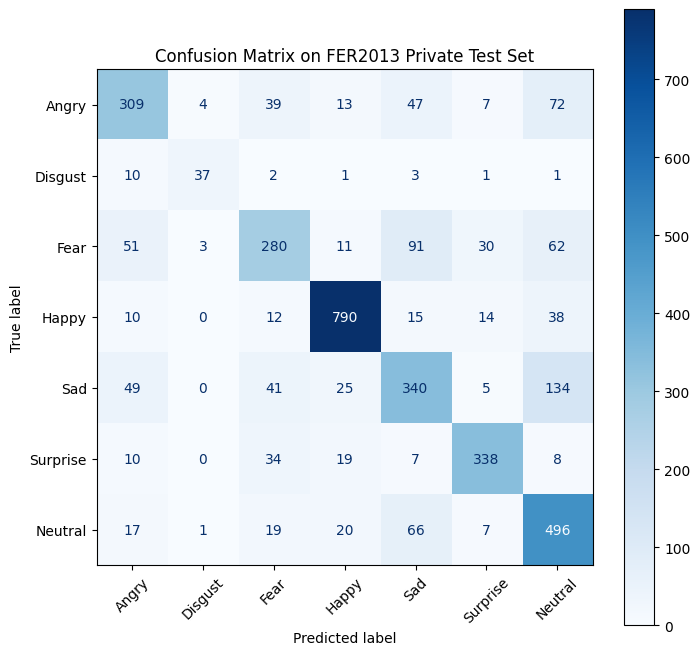

Classification Report:
              precision    recall  f1-score   support

       Angry     0.6776    0.6293    0.6526       491
     Disgust     0.8222    0.6727    0.7400        55
        Fear     0.6557    0.5303    0.5864       528
       Happy     0.8987    0.8987    0.8987       879
         Sad     0.5975    0.5724    0.5847       594
    Surprise     0.8408    0.8125    0.8264       416
     Neutral     0.6116    0.7923    0.6903       626

    accuracy                         0.7216      3589
   macro avg     0.7292    0.7012    0.7113      3589
weighted avg     0.7249    0.7216    0.7200      3589



In [7]:
# =========================================
# Load Model Weights and Compile
# =========================================

model.load_weights('/content/gdrive/My Drive/Colab Notebooks/model_test_Random_Search.h5')

myopt = Adam(learning_rate=0.001)
model.compile(
    optimizer=myopt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =========================================
# Evaluate the Model
# =========================================

score = model.evaluate(x_test_private, y_test_private, verbose=0)
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1] * 100:.2f}%")

# =========================================
# Confusion Matrix and Metrics Computation
# =========================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Step 1: Predict class probabilities
y_pred_probs = model.predict(x_test_private)

# Step 2: Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Convert ground truth one-hot labels to class indices
y_true = np.argmax(y_test_private, axis=1)

# Step 4: Generate and display confusion matrix
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix on FER2013 Private Test Set")
plt.show()

# Step 5: Generate and display classification report
report = classification_report(y_true, y_pred, target_names=emotion_labels, digits=4)
print("Classification Report:")
print(report)